# Noctis Mons
## Pre- fracture Volcanic Surface Reconstruction & Volume Estimation

**Author:** *Faris Beg* 

**Description:**  
This notebook reconstructs the pre-volcanic topography beneath Noctis Mons, Mars, using MOLA spherical harmonic data and QGIS-sampled elevation shapefiles. A ~2000 km regional DEM is extracted and analysed through multi-azimuth elevation profiles to identify the lateral extent of volcanic uplift. The current-day fractured Noctis Mons is then masked and the underlying surface is reconstructed via RBF interpolation on a low-resolution grid. The reconstructed raised surface (from the attached notebook) is inserted back into the regional context, and the resulting uplift grid is used to estimate the volume of the volcanic construct. Profiles are compared with other Martian shield volcanoes for scale.

## 1. Imports

In [ ]:
# Standard scientific stack
import numpy as np
import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d import Axes3D
plt.rcParams.update({'font.size': 12})

# Geospatial
import geopandas as gpd
from shapely.geometry import LineString, MultiLineString

# Interpolation
from scipy.interpolate import Rbf, RBFInterpolator, UnivariateSpline

# Planetary spherical harmonics
import pyshtools as pysh

## 2. Data Loading

### 2a. QGIS-sampled shapefiles
Two point shapefiles are loaded: one for the **base** (low, exposed) surface and one for the **raised** (high) surface of Noctis Mons, sampled in QGIS.

### 2b. Tectonic fault data
Extensional and compressional fault trace GeoJSON files are loaded and will be overlaid on DEM plots for geological context.

### 2c. High-resolution MOLA grid (lmax = 3000)
The MOLA shape model is loaded at full resolution (`lmax = 3000`) and expanded into a global Driscoll–Healy (DH) spatial grid. Two spherical harmonic terms are zeroed before expansion:
- `coeffs[0,0,0]` — the degree-0 term (mean planetary radius); removing it re-centres all elevations around **0 m** relative to the global mean.
- `coeffs[0,2,0]` — the C₂₀ zonal term (polar flattening); removing it isolates local relief from Mars's oblate shape.

A ~2000 km bounding box around Noctis Mons is then extracted by indexing into the DH grid.

At this extent the Noctis2000 MOLA grid shape is: (833, 481)


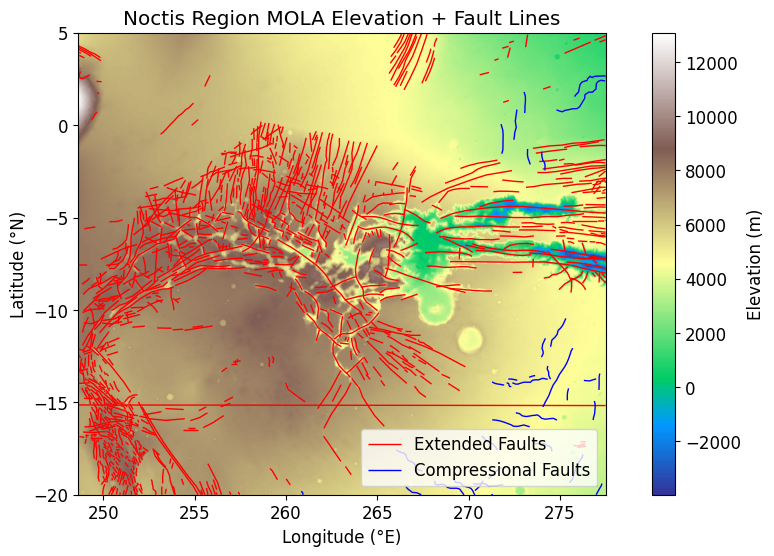

In [2]:
# Load QGIS-sampled shapefiles 
base_layer   = gpd.read_file(r"C:\Users\DELL\Downloads\Volume and Interpolation "
                              r"_Project_layers\elevations_2\base elevations_2.shp")
raised_layer = gpd.read_file(r"C:\Users\DELL\Downloads\Volume and Interpolation "
                              r"_Project_layers\elevations_2\raised elevations_2.shp")

# Extract coordinate and elevation arrays from the attribute table
x_b = base_layer['X'].values
y_b = base_layer['Y'].values
z_b = base_layer['elevations'].values

# Load tectonic fault traces 
ext_gdf  = gpd.read_file("extedatafaults.geojson")
comp_gdf = gpd.read_file("compdatafaults.geojson")

def shift_longitudes(geom):
    """Shift negative longitudes to the 0–360° range to match the DH grid convention."""
    if geom.geom_type == 'LineString':
        return LineString([(lon + 360 if lon < 0 else lon, lat) for lon, lat in geom.coords])
    elif geom.geom_type == 'MultiLineString':
        return MultiLineString([shift_longitudes(line) for line in geom.geoms])
    return geom

# Load high-resolution MOLA spherical harmonic model (lmax = 3000)
mola_sh = pysh.datasets.Mars.MOLA_shape(lmax=3000)
mola_sh.coeffs[0, 0, 0] = 0   # Remove mean planetary radius → elevations relative to 0 m
mola_sh.coeffs[0, 2, 0] = 0   # Remove C20 zonal flattening term

# Expand SH coefficients into a global elevation grid
mola_grid_obj = mola_sh.expand(grid='DH')
mola_grid     = mola_grid_obj.data

# Latitude and longitude axes of the DH grid
lat_mola = mola_grid_obj.lats()
lon_mola = mola_grid_obj.lons()

# Extract 2000 km ROI around Noctis Mons
# Boundaries manually identified on the global map; longitudes shifted to 0–360°
lon_min, lon_max = (-111.37 + 360), (-82.5 + 360)
lat_min, lat_max = -20, 5

# Find grid row/column indices within the bounding box
lon_inds = np.where((lon_mola >= lon_min) & (lon_mola <= lon_max))[0]
lat_inds = np.where((lat_mola >= lat_min) & (lat_mola <= lat_max))[0]

# Slice the global grid to the regional extent
grid_noctis_2000 = mola_grid[np.ix_(lat_inds, lon_inds)]
print("Noctis 2000 km ROI grid shape:", grid_noctis_2000.shape)

# Build equally-spaced coordinate axes for the extracted subgrid
longitudes_extent = np.linspace(lon_min, lon_max, num=grid_noctis_2000.shape[1])
latitudes_extent  = np.linspace(lat_min, lat_max, num=grid_noctis_2000.shape[0])

## 3. Low-Resolution MOLA Grid

A second, lower-resolution version of the MOLA grid is constructed for use in the interpolation step. The MOLA model is downloaded at its default (lower) `lmax`, then expanded with `lmax = 3000` and `lmax_calc = 3000`. Because the underlying harmonic coefficients only extend to the default degree, the higher-degree terms are effectively zero, producing a **smooth, low-resolution** output on the same-shaped grid. Controlling `lmax_calc` rather than the download `lmax` allows the grid shape to be kept constant while adjusting the spatial resolution — this makes arithmetic operations and later grid insertion straightforward.

> All low-resolution variables carry the `_lr` suffix throughout this notebook to distinguish them from their high-resolution counterparts.

At this extent the Noctis2000 MOLA grid shape is: (833, 481)


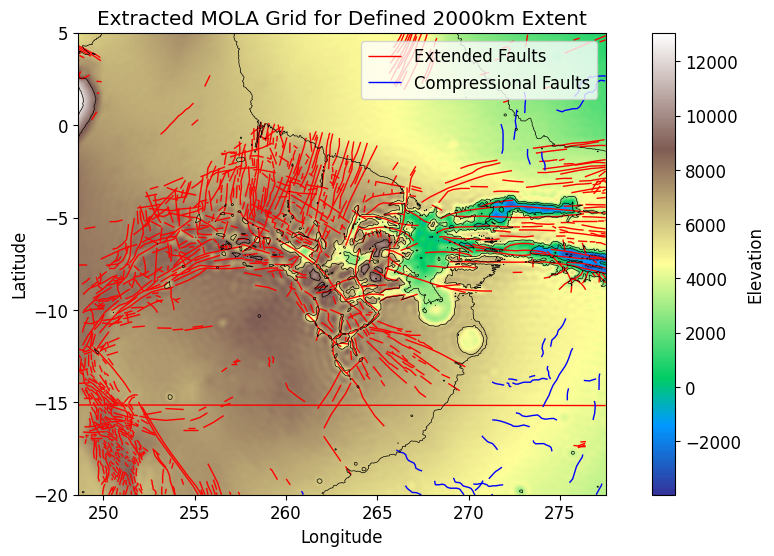

In [27]:
# Download MOLA at default lmax (lower resolution than the 3000-degree model above)
mola_sh_lr = pysh.datasets.Mars.MOLA_shape()
mola_sh_lr.coeffs[0, 0, 0] = 0   # Remove mean planetary radius
mola_sh_lr.coeffs[0, 2, 0] = 0   # Remove C20 zonal flattening term

# Expand with lmax_calc = lmax = 3000; coefficients above the default degree are zero,
# so the result is smooth (low-resolution) while the grid shape matches the HR version
mola_grid_obj_lr = mola_sh_lr.expand(grid='DH', lmax=3000, lmax_calc=3000)
mola_grid_lr     = mola_grid_obj_lr.data

# Define coordinate axes for the LR global grid
lat_mola_lr = np.linspace(90, -90, mola_grid_lr.shape[0])
lon_mola_lr = np.linspace(0, 360,  mola_grid_lr.shape[1])

# Extract the same 2000 km ROI from the LR grid
lon_inds_lr = np.where((lon_mola_lr >= lon_min) & (lon_mola_lr <= lon_max))[0]
lat_inds_lr = np.where((lat_mola_lr >= lat_min) & (lat_mola_lr <= lat_max))[0]
grid_noctis_2000_lr = mola_grid_lr[np.ix_(lat_inds_lr, lon_inds_lr)]
print("LR Noctis 2000 km ROI grid shape:", grid_noctis_2000_lr.shape)

# Coordinate axes for the LR subgrid
longitudes_extent_lr = np.linspace(lon_min, lon_max, num=grid_noctis_2000_lr.shape[1])
latitudes_extent_lr  = np.linspace(lat_min, lat_max, num=grid_noctis_2000_lr.shape[0])

# Clip fault GeoDataFrames to the study-area bounding box
study_box = gpd.GeoDataFrame(geometry=[gpd.GeoSeries([gpd.tools.crs.CRS(4326)]).unary_union], crs=4326)
ext_clip  = ext_gdf.clip(mask=[lon_min - 360, lat_min, lon_max - 360, lat_max])
comp_clip = comp_gdf.clip(mask=[lon_min - 360, lat_min, lon_max - 360, lat_max])
ext_clip.geometry  = ext_clip.geometry.apply(shift_longitudes)
comp_clip.geometry = comp_clip.geometry.apply(shift_longitudes)

# Plot: LR MOLA grid with tectonic fault overlay
fig, ax = plt.subplots(figsize=(12, 6))
im1 = ax.imshow(grid_noctis_2000_lr, origin='upper', cmap='terrain',
                extent=[lon_min, lon_max, lat_min, lat_max])
ext_clip.plot(ax=ax,  linewidth=1, edgecolor='red',  label='Extensional Faults')
comp_clip.plot(ax=ax, linewidth=1, edgecolor='blue', label='Compressional Faults')
plt.contour(longitudes_extent, latitudes_extent, grid_noctis_2000[::-1],
            levels=5, colors='black', linewidths=0.5)
ax.set_title("Low-Resolution MOLA Grid — 2000 km Noctis Mons Extent")
ax.set_xlabel("Longitude")
ax.set_ylabel("Latitude")
plt.colorbar(im1, label="Elevation (m)")
plt.legend()
plt.show()

## 4. Single-Azimuth Elevation Profile — Method Test

A single radial profile is extracted through the Noctis Mons centre at 80° azimuth to verify the profile-extraction and distance-conversion methodology before running it for all azimuths.

- The Noctis centre is pinpointed at **265.4° E, −7.05° N** (geographically identified on the DEM).
- Profile indices are computed geometrically from the centre outward and clipped to grid bounds.
- Along-profile distance is converted to kilometres using cumulative great-circle arcs on Mars (R = 3389.5 km).

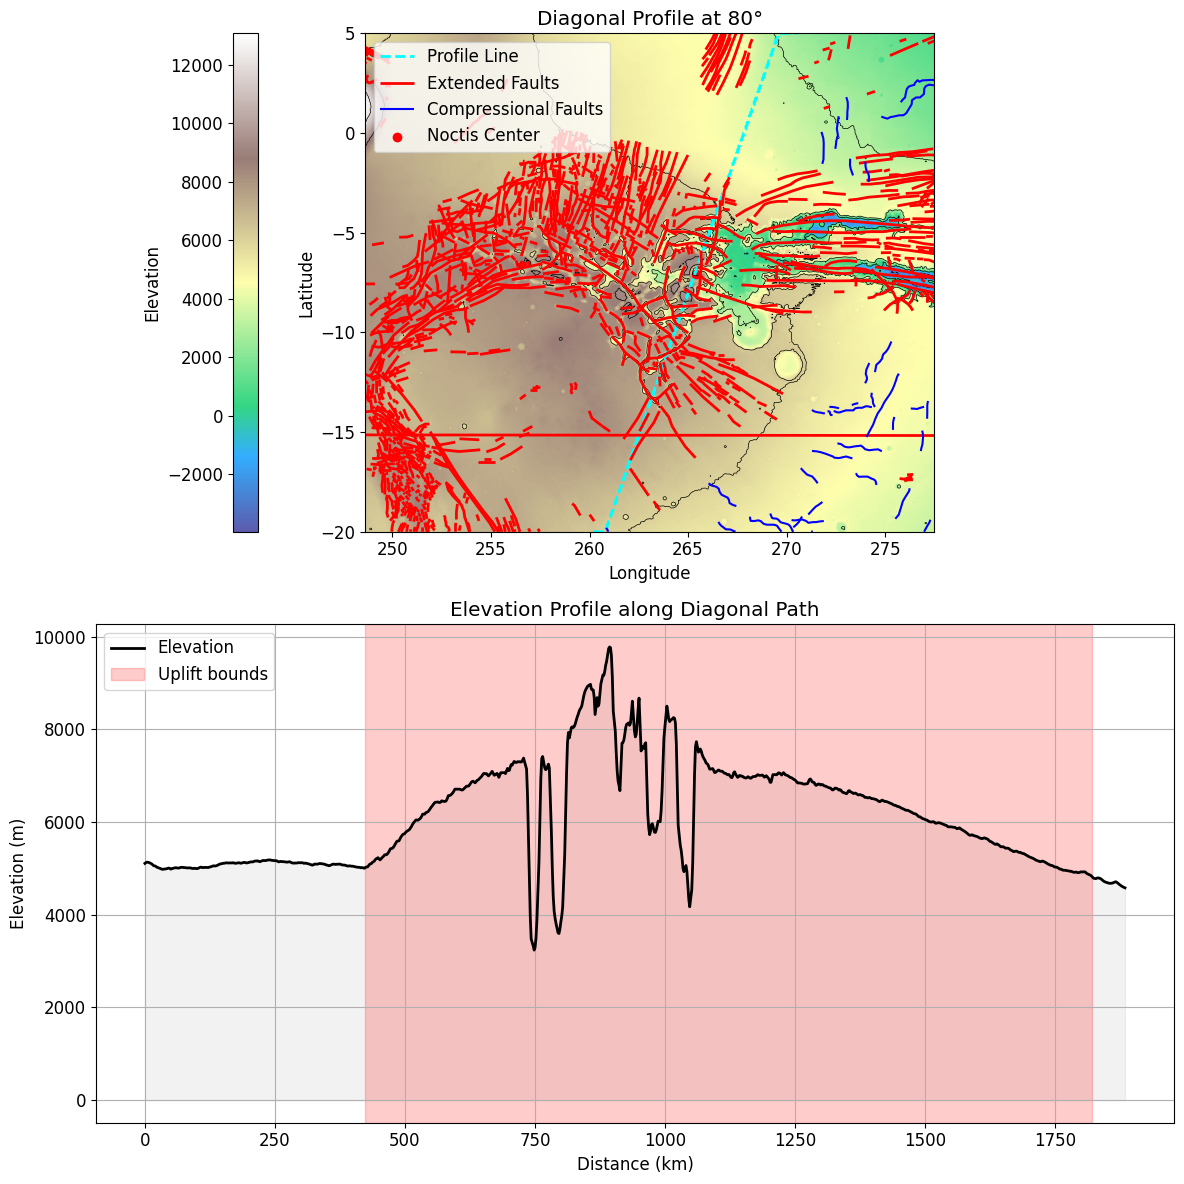

In [52]:
R_mars = 3389.5  # Mars mean radius (km)

# Noctis centre in DH-grid coordinates
noctis_center_lon = -94.60 + 360   # Shift to 0–360° range
noctis_center_lat = -7.05

# Nearest grid indices to the centre point
noctis_center_x = np.argmin(np.abs(longitudes_extent - noctis_center_lon))
noctis_center_y = np.argmin(np.abs(latitudes_extent  - noctis_center_lat))

# Profile geometry (80° azimuth)
angle  = 80    # Azimuth angle in degrees
length = 1000  # Profile length in grid units

dx = length * np.cos(np.radians(angle))
dy = length * np.sin(np.radians(angle))

x_start = int(noctis_center_x - dx / 2)
y_start = int(noctis_center_y - dy / 2)
x_end   = int(noctis_center_x + dx / 2)
y_end   = int(noctis_center_y + dy / 2)

# Interpolate grid indices along the profile line, clipped to valid bounds
x_indices_profile = np.clip(np.linspace(x_start, x_end, num=length),
                             0, grid_noctis_2000.shape[1] - 1).astype(int)
y_indices_profile = np.clip(np.linspace(y_start, y_end, num=length),
                             0, grid_noctis_2000.shape[0] - 1).astype(int)

# Extract elevation values along the profile
elevation_profile = grid_noctis_2000[y_indices_profile, x_indices_profile]

# Convert grid steps to true along-surface distance (km)
lons     = longitudes_extent[x_indices_profile]
lats     = latitudes_extent[y_indices_profile]
lons_rad = np.radians(lons)
lats_rad = np.radians(lats)

# Cumulative great-circle distance using the Haversine formula
distances_km = np.zeros(length)
for i in range(1, length):
    dlat = lats_rad[i] - lats_rad[i - 1]
    dlon = lons_rad[i] - lons_rad[i - 1]
    a = (np.sin(dlat / 2)**2 +
         np.cos(lats_rad[i - 1]) * np.cos(lats_rad[i]) * np.sin(dlon / 2)**2)
    distances_km[i] = distances_km[i - 1] + R_mars * 2 * np.arctan2(np.sqrt(a), np.sqrt(1 - a))

# Plot: map view + elevation profile 
fig, axes = plt.subplots(2, 1, figsize=(12, 12))
ax1, ax2 = axes

# Map with profile line overlaid
im1 = ax1.imshow(grid_noctis_2000, origin='upper', cmap='terrain',
                 extent=[lon_min, lon_max, lat_min, lat_max], alpha=0.8)
ax1.contour(longitudes_extent, latitudes_extent, grid_noctis_2000[::-1],
            levels=5, colors='black', linewidths=0.5, origin='lower')
ax1.plot(lons, lats, color='cyan', linewidth=2, linestyle='--', label='Profile Line')
ext_clip.plot(ax=ax1,  linewidth=2, edgecolor='red',  label='Extensional Faults')
comp_clip.plot(ax=ax1, linewidth=1.5, edgecolor='blue', label='Compressional Faults')
ax1.scatter([noctis_center_lon], [noctis_center_lat], color='red', marker='*',
            s=200, label='Noctis Centre')
plt.colorbar(im1, ax=ax1, label='Elevation (m)')
ax1.set_title('Noctis Mons — 80° Azimuth Profile')
ax1.set_xlabel('Longitude (°)')
ax1.set_ylabel('Latitude (°)')
ax1.legend()

# Elevation vs distance plot
ax2.plot(distances_km, elevation_profile, color='k', linewidth=1.5)
ax2.set_title('Elevation Profile at 80° Azimuth')
ax2.set_xlabel('Distance (km)')
ax2.set_ylabel('Elevation (m)')
ax2.grid(True)
plt.tight_layout()
plt.show()

## 5. Multi-Azimuth Elevation Profiles — Interactive Uplift Bounds

Profiles are extracted radially from the Noctis centre across **35 azimuths** spanning 0–180°. Azimuths between 0–70° pass through Valles Marineris (introducing spuriously low elevations of ~−3000 m that would bias the mean profile), so they are excluded.

An **interactive click handler** is registered on the map: two clicks on the map are used to mark the lateral extent of the volcanic uplift as seen on the overlaid tectonic fault map. These bounds (`highlight_min_1`, `highlight_max_1`) are then used to shade the uplift region on the profile plots.

> **Note:** This cell uses `%matplotlib qt` (interactive backend) so the click handler works. The next cell switches back to `%matplotlib inline`.

In [21]:
%matplotlib qt

# Profile parameters 
azimuths = np.linspace(0, 180, num=35)  # 35 equally-spaced azimuths from 0° to 180°
length   = 1000                         # Profile length in grid units

# Exclude azimuths that pass through Valles Marineris (0°–70°) to avoid
# spuriously low elevations biasing the mean profile
azimuths = azimuths[(azimuths < 0) | (azimuths > 70) & (azimuths < 115) | (azimuths > 180)]

# Containers for profile data
elevation_profiles = []
profile_lons       = []  # Geographic longitudes along each profile
profile_lats       = []  # Geographic latitudes along each profile

# ── Map figure (interactive)
fig, ax = plt.subplots(figsize=(12, 6))
im1 = ax.imshow(grid_noctis_2000, origin='upper', cmap='terrain',
                extent=[lon_min, lon_max, lat_min, lat_max])
ax = plt.gca()
ext_clip.plot(ax=ax,  linewidth=2, edgecolor='red',  label='Extensional Faults')
comp_clip.plot(ax=ax, linewidth=2, edgecolor='blue', label='Compressional Faults')
ax.contour(longitudes_extent, latitudes_extent, grid_noctis_2000[::-1],
           levels=5, colors='black', linewidths=0.5, origin='upper')
ax.scatter([noctis_center_lon], [noctis_center_lat],
           color='red', marker='o', label='Noctis Centre')

# ── Extract profiles at each azimuth ─────────────────────────────────────────
for angle in azimuths:
    dx = length * np.cos(np.radians(angle))
    dy = length * np.sin(np.radians(angle))

    x_start = int(noctis_center_x - dx / 2)
    y_start = int(noctis_center_y - dy / 2)
    x_end   = int(noctis_center_x + dx / 2)
    y_end   = int(noctis_center_y + dy / 2)

    x_indices_profile = np.clip(np.linspace(x_start, x_end, num=length),
                                0, grid_noctis_2000.shape[1] - 1).astype(int)
    y_indices_profile = np.clip(np.linspace(y_start, y_end, num=length),
                                0, grid_noctis_2000.shape[0] - 1).astype(int)

    elevation_profile = grid_noctis_2000[y_indices_profile, x_indices_profile]
    elevation_profiles.append(elevation_profile)

    # Store geographic coordinates of each profile line
    lons = longitudes_extent[x_indices_profile]
    lats = latitudes_extent[y_indices_profile]
    profile_lons.append(lons)
    profile_lats.append(lats)

    ax.plot(lons, lats, '--', linewidth=1.2, label=f"{angle:.1f}°")

# Stack profiles and compute mean
elevation_profiles       = np.array(elevation_profiles)
average_elevation_profile = np.mean(elevation_profiles, axis=0)

ax.set_xlabel("Longitude (°)")
ax.set_ylabel("Latitude (°)")
ax.set_title("Elevation Profiles over Present-Day Noctis Mons")

# ── Interactive click handler: two clicks define the volcanic uplift bounds ──
click_dists    = []
highlight_min_1 = None
highlight_max_1 = None

distance_values = np.linspace(0, length, num=length)  # Profile distance axis (grid units)

def on_click(event):
    global highlight_min_1, highlight_max_1
    if event.inaxes is not ax:
        return
    lon_c, lat_c = event.xdata, event.ydata

    # Find the nearest point across all profiles to the clicked location
    best = {'d2': np.inf}
    for i, (lons, lats) in enumerate(zip(profile_lons, profile_lats)):
        d2 = (lons - lon_c)**2 + (lats - lat_c)**2
        j  = np.argmin(d2)
        if d2[j] < best['d2']:
            best.update(profile=i, idx=j, d2=d2[j])

    matched_dist = distance_values[best['idx']]
    print(f">> Clicked at ({lon_c:.3f}, {lat_c:.3f}); "
          f"nearest profile {azimuths[best['profile']]:.1f}° "
          f"→ distance = {matched_dist:.2f}")
    click_dists.append(matched_dist)

    # Mark click on map
    ax.plot(lon_c, lat_c, marker='x', color='k', markersize=10, markeredgewidth=3)
    fig.canvas.draw()

    # After two clicks, assign the uplift bounds
    if len(click_dists) == 2:
        highlight_min_1, highlight_max_1 = sorted(click_dists)
        print(f"  → highlight_min_1 = {highlight_min_1:.2f}, "
              f"highlight_max_1 = {highlight_max_1:.2f}")

fig.canvas.mpl_connect('button_press_event', on_click)
plt.colorbar(im1, label="Elevation (m)")
plt.legend(markerscale=0.5, fontsize=8, loc='lower left')
plt.show()

>> Clicked at (265.294, -3.063); nearest profile 90.0° → distance = 633.63
>> Clicked at (265.458, -10.747); nearest profile 90.0° → distance = 377.38
  → setting highlight_min_1 = 377.38, highlight_max_1 = 633.63


In [22]:
# Switch back to inline plotting after interactive session
%matplotlib inline

## 6. Individual & Mean Elevation Profiles

All azimuthal profiles are plotted together alongside their mean. The shaded yellow band marks the volcanic uplift window (`highlight_min_1` → `highlight_max_1`) determined interactively from the tectonic fault overlay in the previous step.

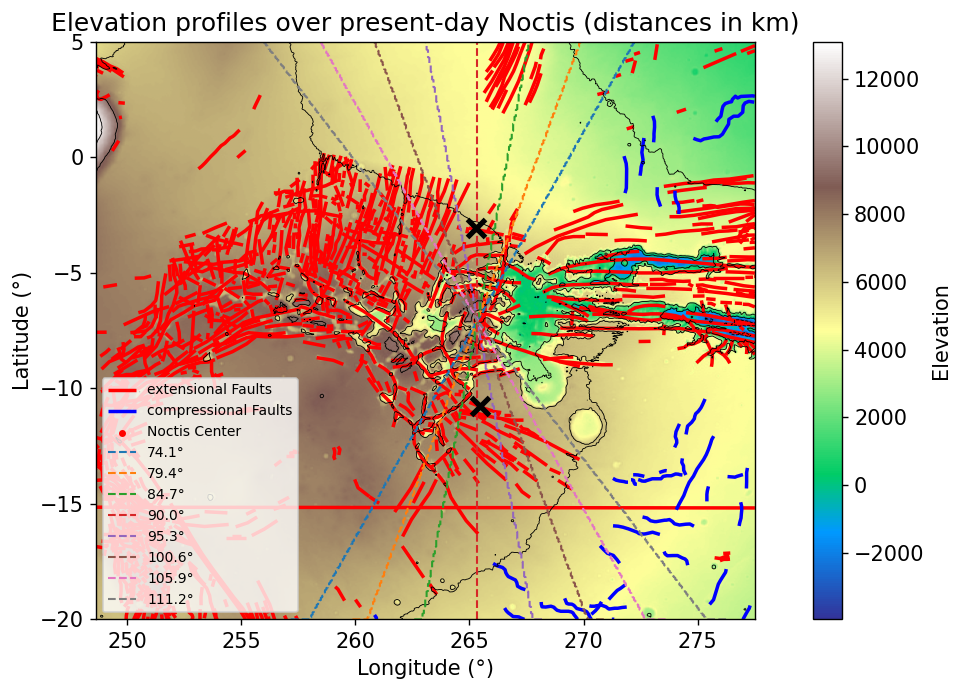

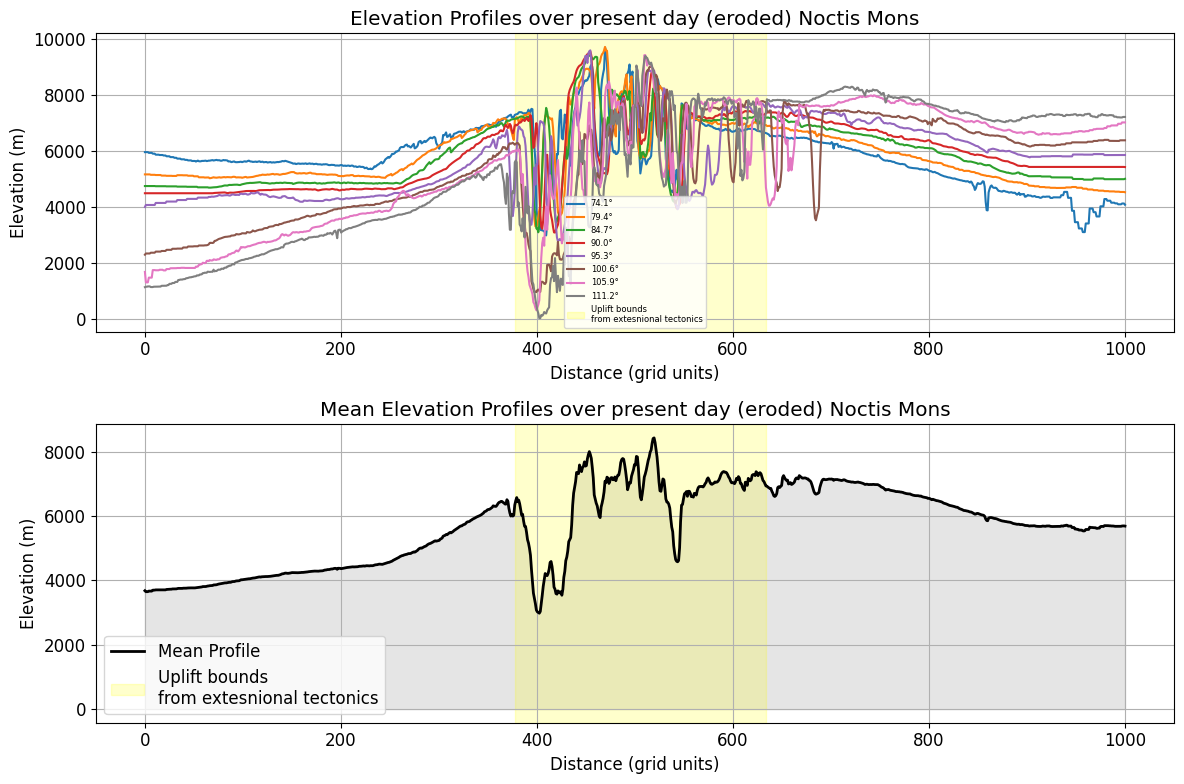

In [23]:
fig, axes = plt.subplots(2, 1, figsize=(12, 8))

# Individual profiles — one line per azimuth
for i, angle in enumerate(azimuths):
    axes[0].plot(distance_values, elevation_profiles[i], linewidth=1.5, label=f'{angle:.1f}°')
axes[0].axvspan(highlight_min_1, highlight_max_1, color='yellow', alpha=0.2,
                label='Uplift bounds (from extensional tectonics)')
axes[0].legend(fontsize=6)
axes[0].set_ylabel("Elevation (m)")
axes[0].set_xlabel("Distance (grid units)")
axes[0].set_title("Elevation Profiles — Present-Day (Eroded) Noctis Mons")
axes[0].grid(True)

# Mean profile with shaded area under the curve
axes[1].plot(distance_values, average_elevation_profile,
             color='black', linewidth=2, label='Mean Profile')
axes[1].fill_between(distance_values, average_elevation_profile, alpha=0.2, color='gray')
axes[1].axvspan(highlight_min_1, highlight_max_1, color='yellow', alpha=0.2,
                label='Uplift bounds (from extensional tectonics)')
axes[1].legend(loc='lower left')
axes[1].set_ylabel("Elevation (m)")
axes[1].set_xlabel("Distance (grid units)")
axes[1].set_title("Mean Elevation Profile — Present-Day Noctis Mons")
axes[1].grid(True)

plt.tight_layout()
plt.show()

## 7. Mean Profile: Volcanic Uplift Removal & Detrending

### 7a. Spline interpolation across the removed section
The volcanic uplift region (the yellow band) is excised from the mean profile and replaced by a smooth spline fitted to the flanking terrain. This gives an estimate of what the pre-volcanic surface would have looked like in the absence of the construct.

### 7b. Detrending
A linear trend between the profile endpoints is subtracted, zeroing both ends and isolating the topographic signal of the uplift from any regional slope.

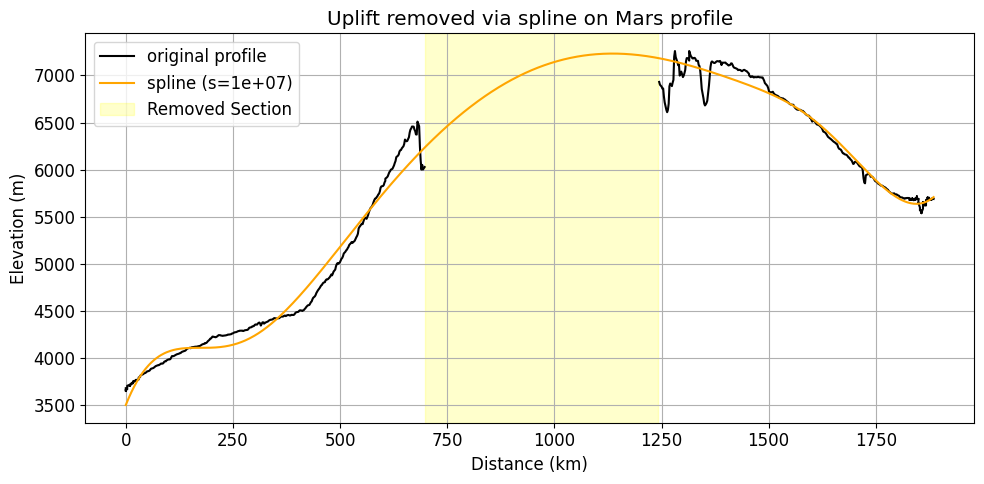

In [24]:
# Spline fit across the volcanic gap 
x_km = distances_km  # True along-profile distance in km

# Convert highlight bounds from grid-unit indices to km
idx_min   = int(highlight_min_1)
idx_max   = int(highlight_max_1)
rem_min_km = distances_km[idx_min]
rem_max_km = distances_km[idx_max]

# Mask out the volcanic section; keep only the flanking terrain for fitting
mask_keep = (x_km < rem_min_km) | (x_km > rem_max_km)
x_keep    = x_km[mask_keep]
y_keep    = average_elevation_profile[mask_keep]

# Sort and deduplicate before fitting the spline
sort_idx          = np.argsort(x_keep)
x_sorted, y_sorted = x_keep[sort_idx], y_keep[sort_idx]
x_u, unique_idx   = np.unique(x_sorted, return_index=True)
y_u               = y_sorted[unique_idx]

# Fit a degree-4 univariate spline to the kept sections
smoothing = 1e7
spl       = UnivariateSpline(x_u, y_u, k=4, s=smoothing)

# Fill the removed section with the spline estimate
y_filled             = average_elevation_profile.copy()
y_filled[~mask_keep] = spl(x_km[~mask_keep])

# Plot: original profile vs spline with gap highlighted
plt.figure(figsize=(10, 5))
plt.plot(x_km[x_km < rem_min_km], average_elevation_profile[x_km < rem_min_km], 'k')
plt.plot(x_km[x_km > rem_max_km], average_elevation_profile[x_km > rem_max_km], 'k',
         label='Original profile')
plt.plot(x_km, spl(x_km), color='orange', label=f'Spline fit (s = {smoothing:.0e})')
plt.axvspan(rem_min_km, rem_max_km, color='yellow', alpha=0.2, label='Removed volcanic section')
plt.xlabel("Distance (km)")
plt.ylabel("Elevation (m)")
plt.title("Spline Fit Across Volcanic Section")
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.show()

0.0 0.0


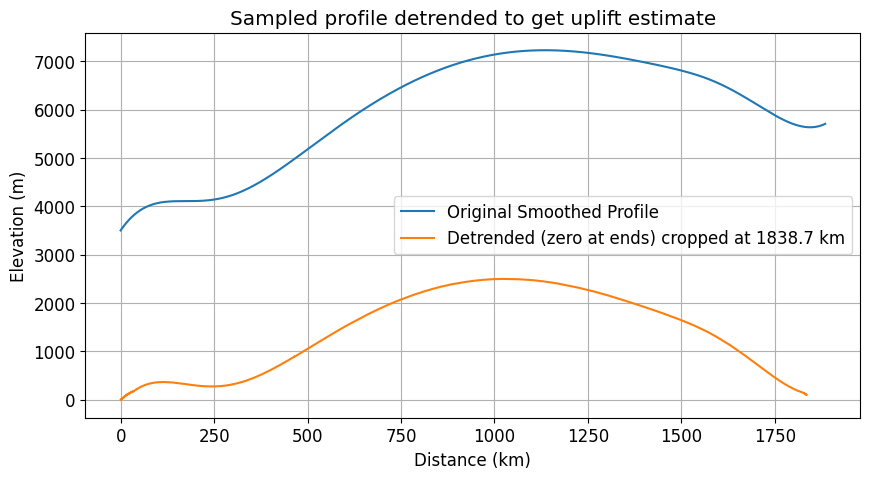

In [25]:
# Detrend the spline profile 
y_spline = spl(x_km)  # Spline evaluated at all true km distances

# Build a linear trend between the two endpoints and subtract it
trend      = np.linspace(y_spline[0], y_spline[-1], num=length)
y_detrended = y_spline - trend

print("Endpoint check (should be ~0):", y_detrended[0], y_detrended[-1])

# Crop at grid-unit index 925 to remove the far edge of the profile where
# the terrain flattens back to background levels
idx_crop = int(925)
crop_km  = distances_km[idx_crop]
mask     = x_km < crop_km

plt.figure(figsize=(10, 5))
plt.plot(x_km, y_spline, label='Smoothed profile (spline)')
plt.plot(x_km[mask], y_detrended[mask],
         label=f'Detrended — cropped at {crop_km:.1f} km')
plt.title("Detrended Mean Profile — Uplift Estimate")
plt.xlabel("Distance (km)")
plt.ylabel("Elevation (m)")
plt.legend()
plt.grid(True)
plt.show()

# Save profile data for use in other notebooks
np.savez('uplift_spline_profile_tectonics.npz',
         x_km=x_km, y_spline=y_spline, y_detrended=y_detrended)

## 8. Pre-Noctis Surface Reconstruction

### Circular mask → RBF interpolation
A circular mask centred on Noctis Mons is applied to the low-resolution MOLA grid, setting the interior to `NaN`. The mask radius is derived from the uplift bounds identified in the elevation profiles: `radius = (269.5° − 262.70°) / 2 ≈ 3.4°`.

The surrounding valid terrain is then used to interpolate back across the masked region using `scipy.interpolate.RBFInterpolator`. Because the full grid is very large, a random subsample of 6000 valid points (with a fixed seed for reproducibility) is used for the fit.

The result, `grid_noctis_filled_lr`, represents the **pre-volcanic (pre-Noctis) elevation surface**.

262.8231152220798 -9.623771691479673


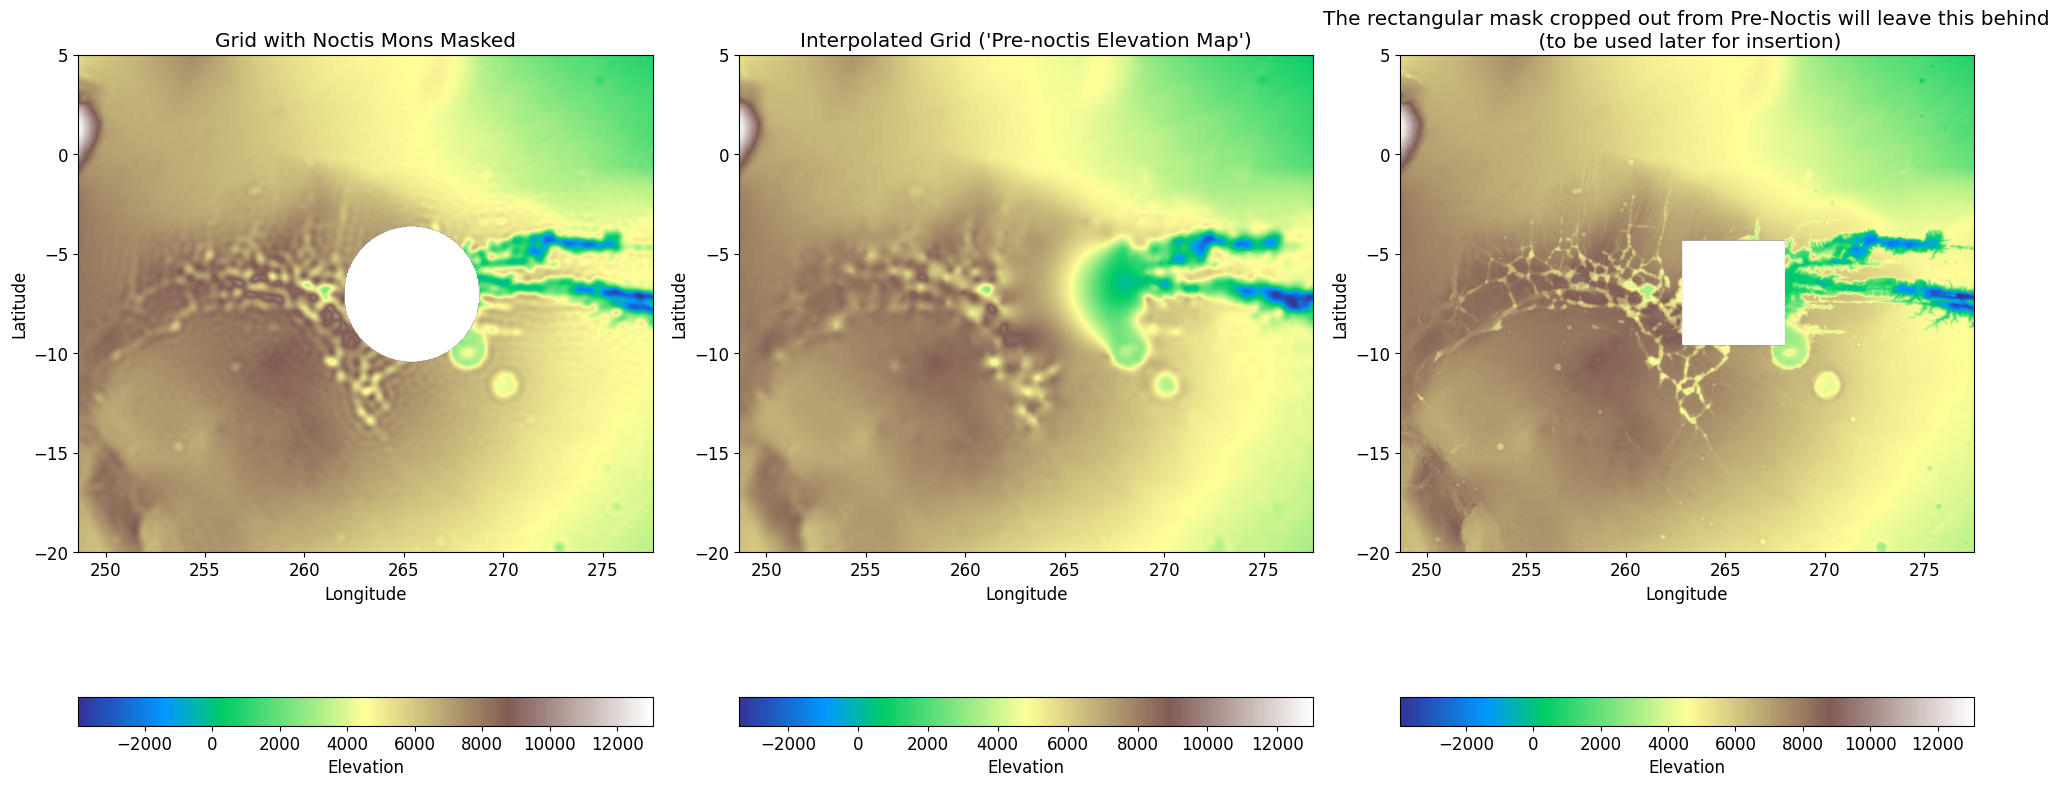

In [28]:
# Load raised-layer sample coordinates (shifted to 0–360° lon convention)
x = raised_layer['X'].values + 360
y = raised_layer['Y'].values
z = raised_layer['elevations'].values

# Build 2-D coordinate grids from the LR subgrid axes 
lon_sub_lr = lon_mola_lr[lon_inds_lr]  # LR longitude values within the ROI
lat_sub_lr = lat_mola_lr[lat_inds_lr]  # LR latitude values within the ROI
lon_grid, lat_grid = np.meshgrid(lon_sub_lr, lat_sub_lr)

# Apply circular mask over the Noctis Mons construct 
nm_lon_center, nm_lat_center = -94.60 + 360, -7.05  # Noctis centre (manually identified)
# Radius in degrees, derived from the lateral uplift bounds observed in the 80° profile
nm_radius = (269.5 - 262.70) / 2

# Boolean mask: True where the point lies inside the Noctis circle
mask_nm_lr = np.sqrt((lon_grid - nm_lon_center)**2 +
                     (lat_grid - nm_lat_center)**2) <= nm_radius

# Set the masked region to NaN (construct removed)
grid_noctis_masked_lr              = grid_noctis_2000_lr.copy()
grid_noctis_masked_lr[mask_nm_lr] = np.nan

# Prepare valid points for RBF interpolation 
valid_mask_lr   = ~np.isnan(grid_noctis_masked_lr)
points_valid_lr  = np.array([lon_grid[valid_mask_lr], lat_grid[valid_mask_lr]]).T
values_valid_lr  = grid_noctis_masked_lr[valid_mask_lr]
points_all_lr    = np.array([lon_grid.ravel(), lat_grid.ravel()]).T

# Subsample 6000 valid points to keep memory usage manageable
# Fixed seed ensures the same points are selected on every run
np.random.seed(42)
sample_indices  = np.random.choice(len(points_valid_lr), size=6000, replace=False)
points_valid_lr = points_valid_lr[sample_indices]
values_valid_lr = values_valid_lr[sample_indices]

# RBF interpolation across the masked region 
rbf_interp          = RBFInterpolator(points_valid_lr, values_valid_lr)
grid_filled_flat_lr = rbf_interp(points_all_lr)

# Reshape flat interpolated array back to grid dimensions
grid_noctis_filled_lr = grid_filled_flat_lr.reshape(grid_noctis_masked_lr.shape)
print("Pre-Noctis filled grid shape:", grid_noctis_filled_lr.shape)

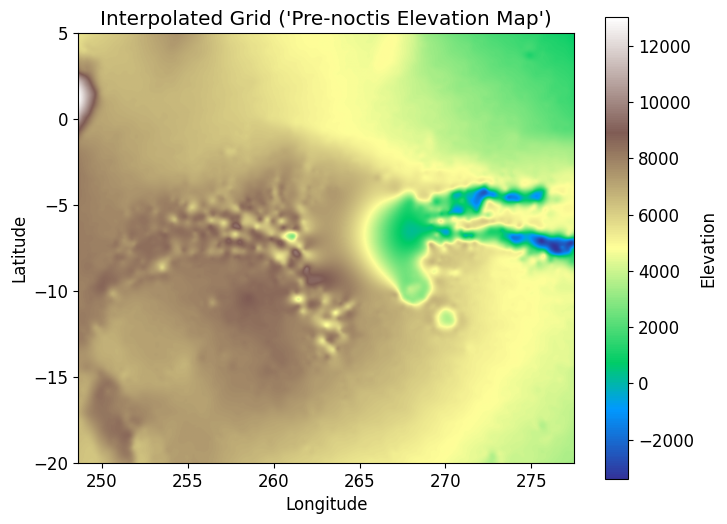

In [43]:
# Standalone view of the reconstructed pre-Noctis elevation map
fig, ax = plt.subplots(figsize=(8, 6))
im3 = ax.imshow(grid_noctis_filled_lr, origin='upper', cmap='terrain',
                extent=[lon_min, lon_max, lat_min, lat_max])
ax.set_title("Reconstructed Pre-Noctis Elevation Map")
ax.set_xlabel("Longitude")
ax.set_ylabel("Latitude")
fig.colorbar(im3, ax=ax, orientation='vertical', label="Elevation (m)")
plt.show()

## 9. Rectangular Crop, Raised Surface Interpolation & Uplift Grid

### Step 1 — Geological context grid
A small MOLA subgrid matching the spatial extent of the raised sample points is extracted to serve as a present-day contour overlay on the plots below.

### Step 2 — Rectangular crop of the pre-Noctis map
A rectangular region is carved out of `grid_noctis_filled_lr` whose bounds match those of the raised shapefile samples. A circular interpolated region cannot be used directly for arithmetic with the raised surface interpolation because the raised surface grid is inherently rectangular.

### Step 3 — RBF interpolation of raised sample points
The raised elevation samples are interpolated onto the same rectangular grid using RBF (linear kernel), producing `grid_z_spline_r`.

### Step 4 — Uplift grid
The uplift grid is defined as:

$$\text{uplift\_grid} = \text{grid\_z\_spline\_r} - \text{grid\_noctis\_cropped}$$

representing the height of the volcanic surface above the reconstructed pre-volcanic plain.

In [44]:
# Extract a MOLA subgrid matching the raised sample extent for contour overlays
lon_min_rect, lon_max_rect = min(x), max(x)
lat_min_rect, lat_max_rect = min(y), max(y)

lon_inds_rect = np.where((lon_mola >= lon_min_rect) & (lon_mola <= lon_max_rect))[0]
lat_inds_rect = np.where((lat_mola >= lat_min_rect) & (lat_mola <= lat_max_rect))[0]

grid_noctis_rect_elevation = mola_grid[np.ix_(lat_inds_rect, lon_inds_rect)]
print("Context grid shape:", grid_noctis_rect_elevation.shape)

 Because it is cut for the same extent from the same larger grid (grid_noctis_2000), the shape should match)
 Noctis rectangular MOLA grid shape ): (175, 86)


cropped grid shape: (175, 86)
Raised interpolation grid shape:(175, 86)


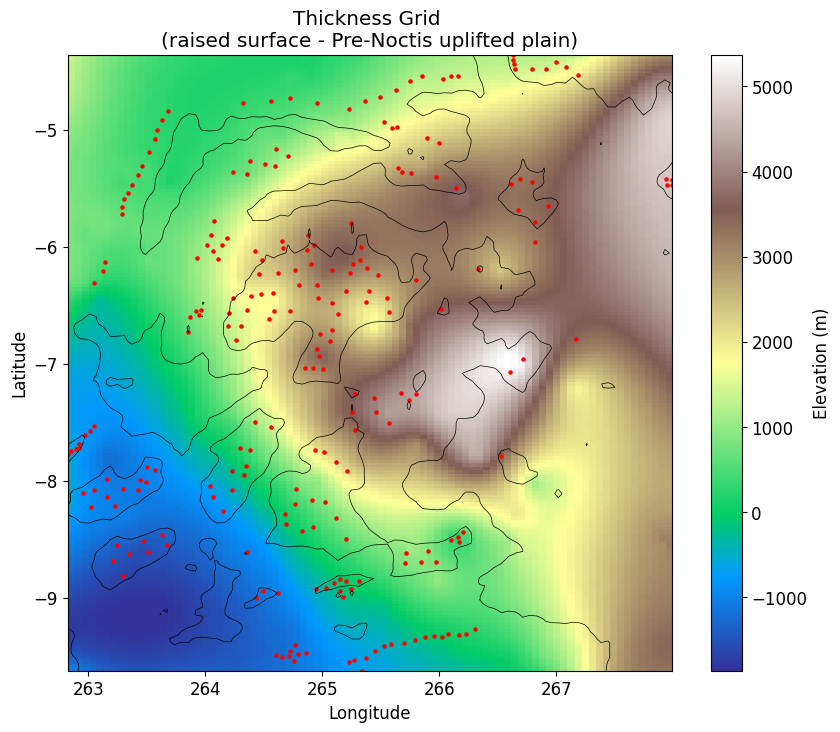

Maximum uplifted point recorded:5.371858930768151 kms 
 This will represent the highest elevation of the entire bulge
Shape of the uplift grid: (175, 86)


In [45]:
# Rectangular crop of the pre-Noctis map
# Bounds match the raised sample points' spatial extent
lon_min_crop, lon_max_crop = min(x), max(x)
lat_min_crop, lat_max_crop = min(y), max(y)

# Find column indices using searchsorted on the sorted LR longitude axis
lon_idx_min = np.searchsorted(lon_sub_lr, min(x))
lon_idx_max = np.searchsorted(lon_sub_lr, max(x))

# Find row indices using a boolean mask on the LR latitude axis
lat_mask   = (lat_sub_lr >= min(y)) & (lat_sub_lr <= max(y))
row_indices = np.where(lat_mask)[0]

if row_indices.size > 0:
    grid_noctis_cropped = grid_noctis_filled_lr[
        row_indices[0]:row_indices[-1] + 1, lon_idx_min:lon_idx_max
    ]
else:
    raise ValueError("No latitude values found within the specified range.")

# RBF interpolation of raised elevation samples
# Output grid matches the shape of the cropped pre-Noctis grid
grid_x, grid_y = np.meshgrid(
    np.linspace(min(x), max(x), np.shape(grid_noctis_cropped)[1]),
    np.linspace(min(y), max(y), np.shape(grid_noctis_cropped)[0])
)
rbf_interpolator = Rbf(x, y, z, function='linear')
grid_z_spline_r  = rbf_interpolator(grid_x, grid_y)

print(f'Cropped pre-Noctis grid shape:     {grid_noctis_cropped.shape}')
print(f'Raised interpolation grid shape:   {grid_z_spline_r.shape}')

# Compute uplift grid: raised surface minus pre-Noctis plain
uplift_grid = grid_z_spline_r - grid_noctis_cropped

# 3-panel verification plot 
fig, axes = plt.subplots(1, 3, figsize=(20, 7))
ax1, ax2, ax3 = axes

# Panel 1: Cropped pre-Noctis plain with present-day contour overlay
im1 = ax1.imshow(grid_noctis_cropped, origin='upper', cmap='terrain',
                 extent=[min(x), max(x), min(y), max(y)])
ax1.contour(grid_x, grid_y, grid_noctis_rect_elevation[::-1],
            levels=2, colors='black', linewidths=0.5)
ax1.set_xlabel("Longitude")  ;  ax1.set_ylabel("Latitude")
ax1.set_title("Reconstructed Pre-Noctis Plain (Cropped)")

# Panel 2: Interpolated raised surface with sample point overlay
im2 = ax2.imshow(grid_z_spline_r, origin='upper', cmap='terrain',
                 extent=[min(x), max(x), min(y), max(y)])
ax2.contour(grid_x, grid_y, grid_noctis_rect_elevation[::-1],
            levels=2, colors='black', linewidths=0.5)
ax2.scatter(x, y, c='r', s=5)
ax2.set_xlabel("Longitude")  ;  ax2.set_ylabel("Latitude")
ax2.set_title("Interpolated Raised Surface (RBF)")

# Panel 3: Uplift grid
im3 = ax3.imshow(uplift_grid, origin='upper', cmap='terrain',
                 extent=[min(x), max(x), min(y), max(y)])
ax3.contour(grid_x, grid_y, grid_noctis_rect_elevation[::-1],
            levels=2, colors='black', linewidths=0.5)
ax3.scatter(x, y, c='r', s=5, label='Raised sample points')
ax3.set_xlabel("Longitude")  ;  ax3.set_ylabel("Latitude")
ax3.set_title('Uplift Grid\n(Raised surface − Pre-Noctis plain)')
fig.colorbar(im3, ax=ax3, label='Uplift (m)')

plt.tight_layout()
plt.show()

print(f'Maximum uplift: {np.max(uplift_grid) / 1000:.3f} km ')
print(f'Uplift grid shape: {uplift_grid.shape}')

np.save('uplift_grid.npy', uplift_grid)

## 10. Insertion: Raised Surface into Regional Pre-Noctis Context

The interpolated raised surface (`grid_z_spline_r`) is inserted back into the full pre-Noctis regional map (`grid_noctis_filled_lr`) at the matching row/column indices. This produces `inserted` — a reconstruction of the regional topography as it would appear if Noctis Mons were present above the pre-volcanic plain. The shape verification confirms that the raised grid exactly fills the target slot.

In [46]:
# Verify that the raised grid shape matches the target slot before insertion
print("Raised interpolated grid shape:",
      grid_z_spline_r.shape)
print("Target slot shape:",
      grid_noctis_filled_lr[row_indices[0]:row_indices[-1]+1, lon_idx_min:lon_idx_max].shape)

# Copy the pre-Noctis regional map and insert the raised surface at the correct position
inserted = grid_noctis_filled_lr.copy()
inserted[row_indices[0]:row_indices[-1] + 1, lon_idx_min:lon_idx_max] =+ grid_z_spline_r

# Plot: inserted raised surface in regional context
plt.figure(figsize=(20, 10))
im1 = plt.imshow(inserted, origin='upper', cmap='terrain',
                 extent=[lon_min, lon_max, lat_min, lat_max])
# Present-day contour lines for geological context
plt.contour(grid_x, grid_y, grid_noctis_rect_elevation[::-1],
            levels=1, colors='k', origin='upper')
plt.scatter(x, y, c='r', s=0.3, label='Raised sample points')
plt.colorbar(im1, label='Elevation (m)')
plt.title("Reconstructed Noctis Mons in Regional Pre-Volcanic Context")
plt.xlabel("Longitude")
plt.ylabel("Latitude")
plt.show()

Shape of rasied interpolated grid: (175, 86)
Shape of target region: (175, 86)


## 11. Elevation Profiles over the Reconstructed Surface

Multi-azimuth profiles are extracted over the `inserted` grid (the reconstructed Noctis Mons above the pre-volcanic plain) to visualise the volcanic edifice shape in cross-section. Profile distances are converted to kilometres using the pixel size at the Noctis centre latitude.

In [54]:
# ── Profile parameters (same azimuths as before, Valles Marineris excluded) ─
azimuths = np.linspace(0, 180, num=35)
length   = 1000
azimuths = azimuths[(azimuths < 0) | ((azimuths > 70) & (azimuths < 115)) | (azimuths > 180)]

elevation_profiles = []

# Convert pixel size to km at the Noctis centre latitude
lat_res_deg    = np.abs(latitudes_extent[1]  - latitudes_extent[0])
lon_res_deg    = np.abs(longitudes_extent[1] - longitudes_extent[0])
mars_radius_km = 3389.5
deg_to_km      = (np.pi / 180) * mars_radius_km
lat_km_per_deg = deg_to_km
lon_km_per_deg = deg_to_km * np.cos(np.radians(noctis_center_lat))
pixel_scale_km = np.sqrt((lon_res_deg * lon_km_per_deg)**2 + (lat_res_deg * lat_km_per_deg)**2)
distance_values_km = np.linspace(0, length * pixel_scale_km, num=length)

# Map with profile lines
plt.figure(figsize=(12, 6))
im1 = plt.imshow(inserted, origin='upper', cmap='terrain',
                 extent=[lon_min, lon_max, lat_min, lat_max])
plt.contour(grid_x, grid_y, grid_noctis_rect_elevation[::-1], levels=1, colors='k', origin='upper')
plt.scatter(x, y, c='r', s=0.1)

noctis_center_lon = -94.60 + 360
noctis_center_lat = -7.05
noctis_center_x   = np.argmin(np.abs(longitudes_extent - noctis_center_lon))
noctis_center_y   = np.argmin(np.abs(latitudes_extent  - noctis_center_lat))

for angle in azimuths:
    dx = length * np.cos(np.radians(angle))
    dy = length * np.sin(np.radians(angle))
    x_start = int(noctis_center_x - dx / 2)
    y_start = int(noctis_center_y - dy / 2)
    x_end   = int(noctis_center_x + dx / 2)
    y_end   = int(noctis_center_y + dy / 2)
    x_indices_profile = np.clip(np.linspace(x_start, x_end, num=length),
                                0, inserted.shape[1] - 1).astype(int)
    y_indices_profile = np.clip(np.linspace(y_start, y_end, num=length),
                                0, inserted.shape[0] - 1).astype(int)
    elevation_profile = inserted[y_indices_profile, x_indices_profile]
    elevation_profiles.append(elevation_profile)
    plt.plot(longitudes_extent[x_indices_profile], latitudes_extent[y_indices_profile],
             linewidth=1.5, linestyle='--', label=f"{angle:.1f}°")

plt.legend(markerscale=0.3, loc='lower left', fontsize=8)
plt.title("Reconstructed Noctis — Profile Lines")
plt.xlabel("Longitude")
plt.ylabel("Latitude")
plt.colorbar(im1, label='Elevation (m)', location='right')
plt.show()

# Profile plots
elevation_profiles        = np.array(elevation_profiles)
average_elevation_profile = np.mean(elevation_profiles, axis=0)

fig, axes = plt.subplots(2, figsize=(12, 12), sharex=True)

for i, angle in enumerate(azimuths):
    axes[0].plot(distance_values_km, elevation_profiles[i], linewidth=1.5, label=f'{angle:.1f}°')
axes[0].set_ylabel("Elevation (m)")
axes[0].set_title("Elevation Profiles — Reconstructed Noctis Mons")
axes[0].legend(fontsize=8)
axes[0].grid(True)

axes[1].plot(distance_values_km, average_elevation_profile,
             color='black', linewidth=2, label='Mean Profile')
axes[1].fill_between(distance_values_km, average_elevation_profile, alpha=0.2, color='gray')
axes[1].set_ylabel("Elevation (m)")
axes[1].set_xlabel("Distance (km)")
axes[1].set_title("Mean Profile — Reconstructed Noctis Shape")
axes[1].legend(fontsize=8)

plt.tight_layout()
plt.show()

print("Maximum mean elevation over reconstructed surface:", np.max(average_elevation_profile), "m")

Maximum mean elevation: 8693.61293752469


## 12. Comparison with Other Martian Shield Volcanoes

To contextualise the scale of Noctis Mons, elevation profiles are extracted for **Tharsis Tholus** and **Hecates Tholus** — two Martian shield volcanoes of intermediate size — and compared with the mean Noctis profile.

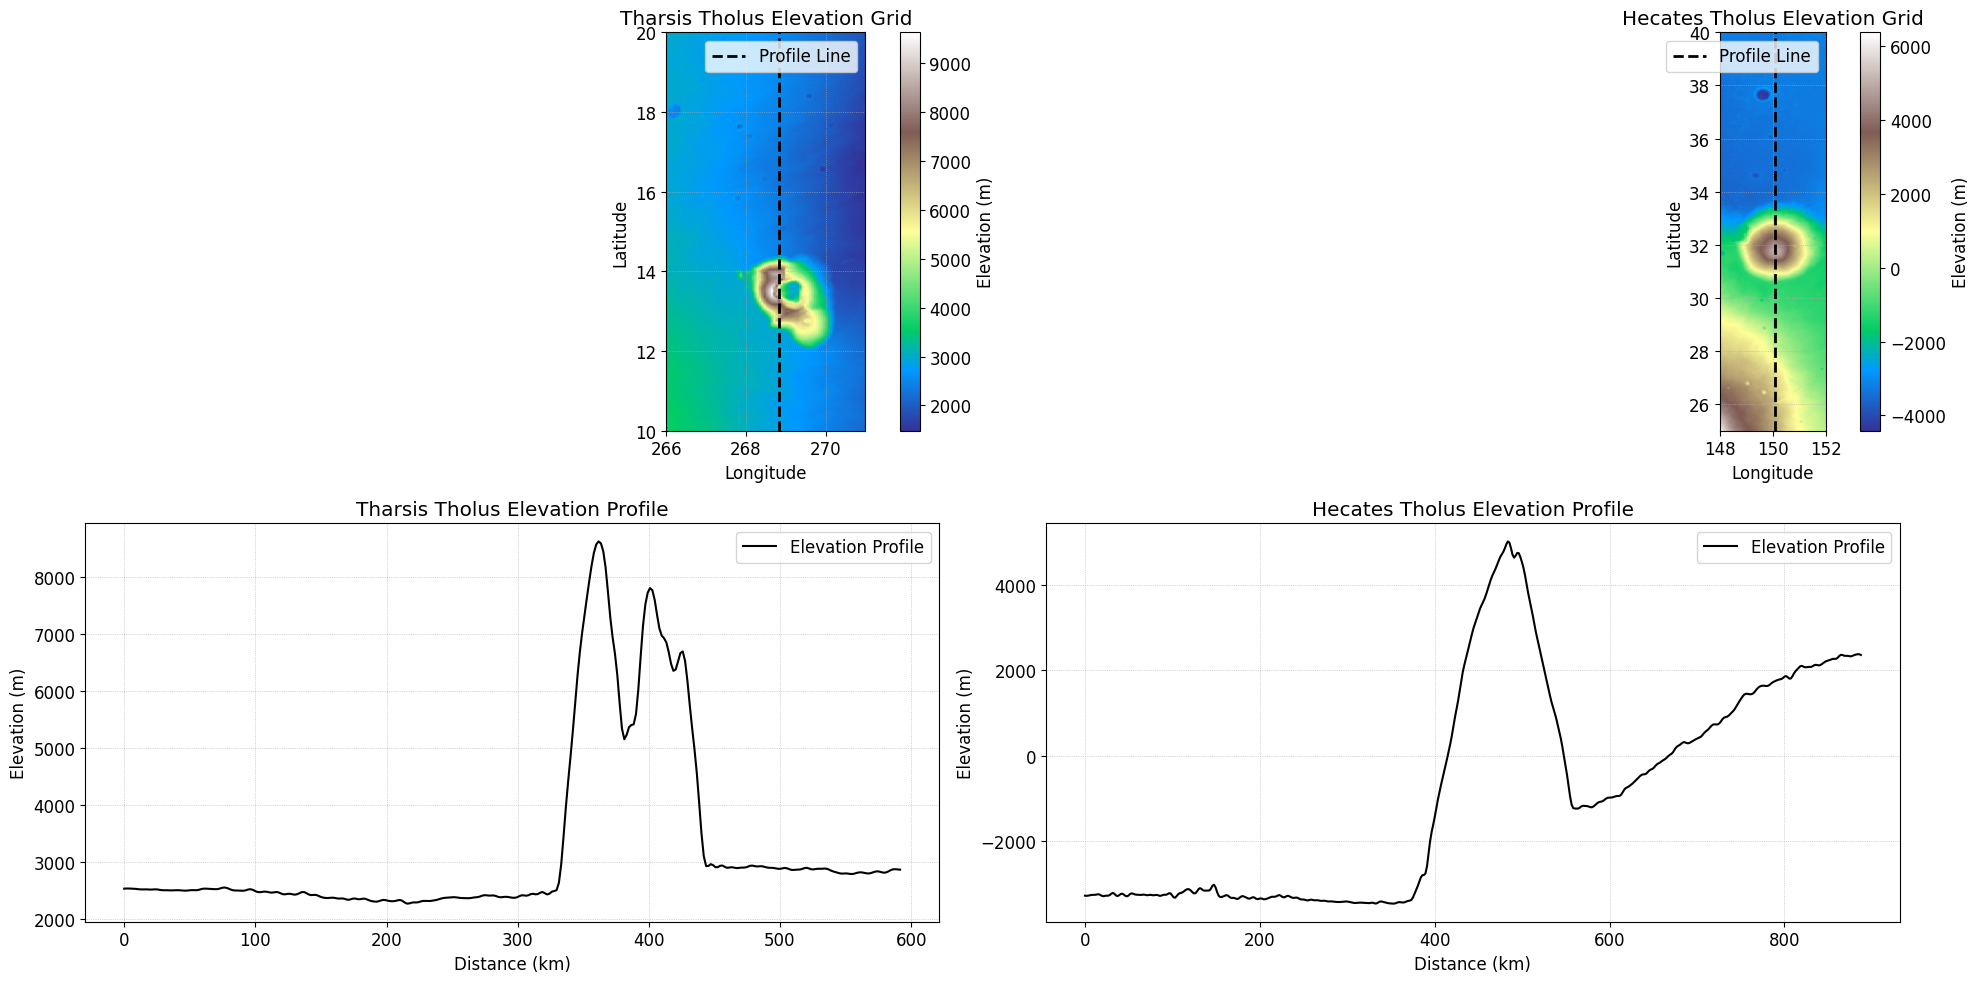

In [50]:
R_MARS = 3389.5  # Mars mean radius (km)

# Define bounding box and vertical-profile column index for each comparison volcano
regions = {
    "Tharsis Tholus": {"lon_min": 266, "lon_max": 271,
                        "lat_min": 10,  "lat_max": 20,  "profile_idx": 47},
    "Hecates Tholus":  {"lon_min": 148, "lon_max": 152,
                        "lat_min": 25,  "lat_max": 40,  "profile_idx": 34}
}

fig, axes = plt.subplots(2, 2, figsize=(20, 10))
profile_data = {}

for i, (name, params) in enumerate(regions.items()):
    # Extract DEM subgrid for this volcano
    lon_inds = np.where((lon_mola >= params["lon_min"]) & (lon_mola <= params["lon_max"]))[0]
    lat_inds = np.where((lat_mola >= params["lat_min"]) & (lat_mola <= params["lat_max"]))[0]
    grid_region = mola_grid[np.ix_(lat_inds, lon_inds)]

    # Build latitude axis and convert to km from the southern edge
    latitudes   = np.linspace(params["lat_min"], params["lat_max"], grid_region.shape[0])
    distance_km = (latitudes - latitudes[0]) * (np.pi / 180) * R_MARS

    # Extract the vertical profile at the specified column index
    elevation_profile = grid_region[:, params["profile_idx"]]
    profile_data[name] = {"latitudes": latitudes,
                           "elevation_profile": elevation_profile,
                           "distance_km": distance_km}

    # Top row: DEM image with profile line
    im = axes[0, i].imshow(grid_region, origin='upper', cmap='terrain',
                           extent=[params["lon_min"], params["lon_max"],
                                   params["lat_min"],  params["lat_max"]])
    lon_axis = np.linspace(params["lon_min"], params["lon_max"], grid_region.shape[1])
    axes[0, i].axvline(x=lon_axis[params["profile_idx"]],
                       color='k', linestyle='--', linewidth=2, label='Profile Line')
    axes[0, i].set_title(f"{name} — Elevation Grid")
    axes[0, i].set_xlabel("Longitude")
    axes[0, i].set_ylabel("Latitude")
    axes[0, i].grid(True, linestyle=':', linewidth=0.5)
    axes[0, i].legend()
    fig.colorbar(im, ax=axes[0, i], orientation='vertical',
                 fraction=0.046, pad=0.04).set_label("Elevation (m)")

    # Bottom row: elevation vs distance profile
    axes[1, i].plot(distance_km, elevation_profile, color='k', label='Elevation Profile')
    axes[1, i].set_title(f"{name} — Elevation Profile")
    axes[1, i].set_xlabel("Distance (km)")
    axes[1, i].set_ylabel("Elevation (m)")
    axes[1, i].grid(True, linestyle=':', linewidth=0.5)
    axes[1, i].legend()

plt.tight_layout()
plt.show()

<Figure size 1200x600 with 0 Axes>

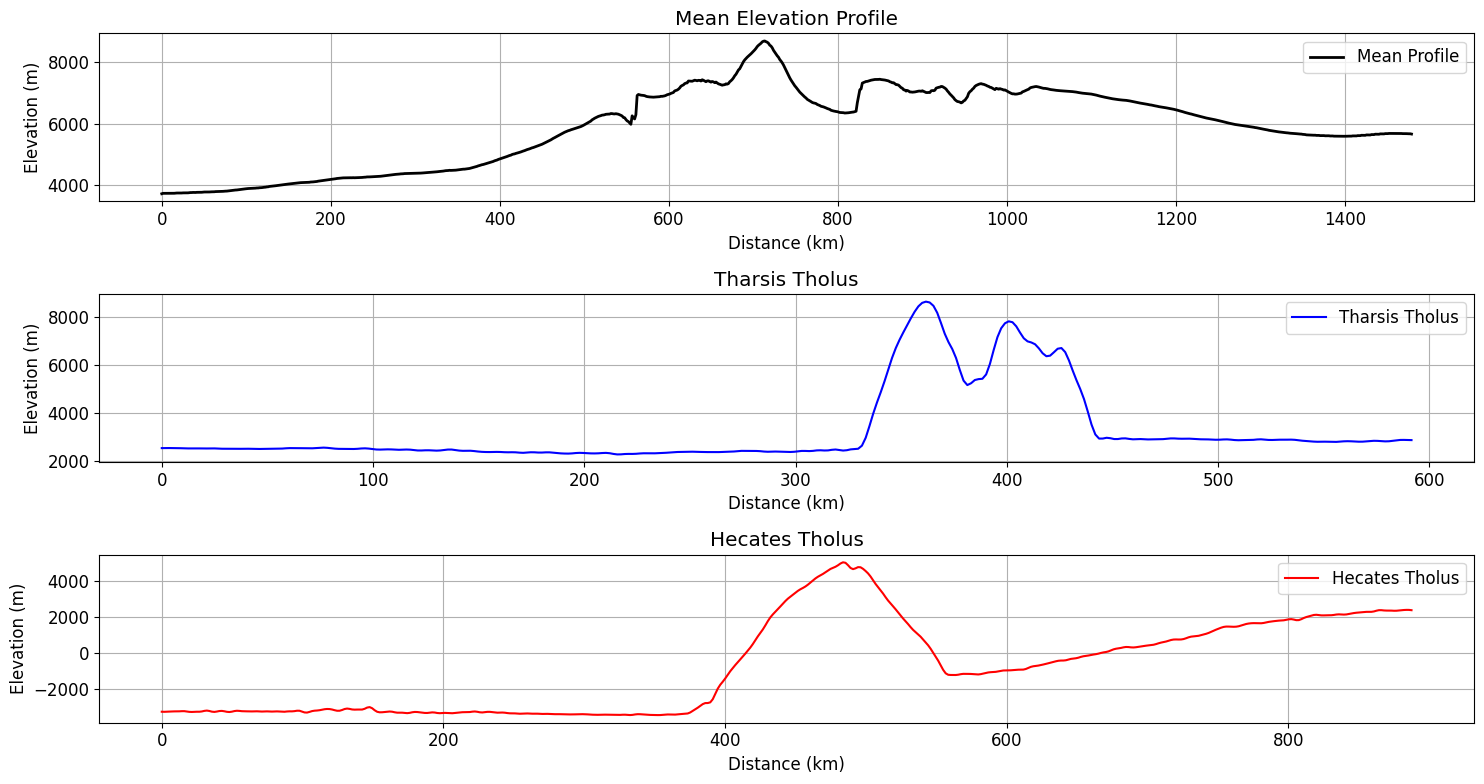

In [56]:
fig, axes = plt.subplots(3, 1, figsize=(15, 10))
ax1, ax2, ax3 = axes

# Mean profile of Noctis (converted to km on the x-axis)
lat_min_mean, lat_max_mean = -20, 5
N_mean         = average_elevation_profile.shape[0]
latitudes_mean = np.linspace(lat_min_mean, lat_max_mean, N_mean)
distance_mean_km = (latitudes_mean - latitudes_mean[0]) * (np.pi / 180) * R_MARS

ax1.plot(distance_mean_km, average_elevation_profile,
         color='black', linewidth=2, label='Noctis Mons — Mean Profile')
ax1.set_title('Noctis Mons — Mean Elevation Profile')
ax1.set_xlabel('Distance (km)')  ;  ax1.set_ylabel('Elevation (m)')
ax1.grid(True)  ;  ax1.legend()

# Tharsis Tholus profile
ax2.plot(profile_data['Tharsis Tholus']['distance_km'],
         profile_data['Tharsis Tholus']['elevation_profile'],
         label='Tharsis Tholus', color='blue')
ax2.set_title('Tharsis Tholus')  ;  ax2.set_xlabel('Distance (km)')
ax2.set_ylabel('Elevation (m)')  ;  ax2.grid(True)  ;  ax2.legend()

# Hecates Tholus profile
ax3.plot(profile_data['Hecates Tholus']['distance_km'],
         profile_data['Hecates Tholus']['elevation_profile'],
         label='Hecates Tholus', color='red')
ax3.set_title('Hecates Tholus')  ;  ax3.set_xlabel('Distance (km)')
ax3.set_ylabel('Elevation (m)')  ;  ax3.grid(True)  ;  ax3.legend()

plt.tight_layout()
plt.show()

## 13. Volume Estimation

The volume of the uplifted region is computed by integrating the uplift grid over its area. Each grid cell's area is calculated using the spherical surface element:

$$dA = R_{\text{Mars}}^2 \sin(\phi + 90°)\, d\theta\, d\phi$$

A threshold of 1500 m is applied (`pyro_elevation`) to isolate only the elevated volcanic region, and an additional longitude filter (`grid_x < 267°`) restricts the calculation to the main Noctis construct, excluding outlying uplifted terrain to the east.

> **Interpretation note:** This volume estimate represents the uplifted terrain above the reconstructed pre-Noctis plain — not the total volcanic edifice volume.

In [74]:
# Define the uplifted region of interest
pyro_elevation = 1500  # Minimum uplift threshold to isolate the volcanic construct (m)

# Boolean mask: cells above the elevation threshold AND west of 267° longitude
mask_pyro = (uplift_grid > pyro_elevation) & (grid_x < 267)

# Zero out cells outside the mask while keeping the grid shape intact
uplift_grid_1 = np.where(mask_pyro, uplift_grid, 0.0)

# Compute spherical grid-cell areas
R_Mars = 3389.5  # Mars mean radius (km)

# Use the MOLA default expansion to get the angular step size
Mars_MOLA = pysh.datasets.Mars.MOLA_shape().expand()
step = 360 / (2 * Mars_MOLA.n)  # Angular step in degrees

# Reuse the interpolation coordinate grids as the spatial reference
grid_lon = grid_x
grid_lat = grid_y

# Spherical surface element: R² sin(co-latitude) dθ dφ → km²
area_uplifted_grid = (R_Mars**2
                      * np.sin((grid_lat + 90) * np.pi / 180)
                      * (step * np.pi / 180)**2)

total_area = np.sum(area_uplifted_grid)
print(f'Area grid shape:       {area_uplifted_grid.shape}')
print(f'Total study area:      {total_area:.1f} km²')

# Integrate: volume = area × uplift height
volume_grid  = area_uplifted_grid * (uplift_grid_1 / 1000)  # Convert uplift m → km
total_volume = np.sum(volume_grid)  # km³
print(f'Estimated uplifted volume of Noctis Mons: {total_volume:.0f} km³')

n that determines resolution = 87
shape of the area_uplifted grid (175, 86) columns and rows
total area of  the uplifted region: 816558.0858037819 km2
The volume of the uplifted region of Noctis Mons will be : 751023.1683247552 km3
 note that this is not the volume of the Nocti Mons itself but the region that is uplifted


## 14. Volume Comparison with Major Martian Volcanoes

| Volcano | Estimated Volume |
|---|---|
| **Noctis Mons** (uplifted region) | ~0.7 million km³ |
| Pavonis Mons (~14 km tall) | ~250,000 km³ |
| Ascraeus Mons | ~1.2 million km³ |
| Alba Mons | ~2.5 million km³ |
| Olympus Mons | ~4 million km³ |

> The Noctis Mons uplifted volume falls between Pavonis and Ascraeus Mons, consistent with an intermediate-scale volcanic edifice. Note that this estimate reflects the uplifted bulge above the pre-volcanic surface, not the full volcanic cone volume.

In [75]:
# 3-D surface visualisation of the uplift grid
fig = plt.figure(figsize=(12, 8))
ax  = fig.add_subplot(111, projection='3d')
ax.plot_surface(grid_lon, grid_lat, uplift_grid, cmap='terrain')
ax.contour(grid_x, grid_y, grid_noctis_rect_elevation,
           levels=2, colors='black', linewidths=0.5)
ax.set_title('3-D Uplift Surface — Noctis Mons')
ax.set_xlabel('Longitude')
ax.set_ylabel('Latitude')
ax.set_zlabel('Uplift (m)')
plt.show()